# Some insights:

TYPE OF ML PROBLEM: There are nine different classes a genetic mutation can be classified into Multi class classification problem

PERFORMANCE METRIC USED: Multi-class log-loss, Confusion Matrix

OBJECTIVE: Objective: Predict the probability of each data-point belonging to each of the nine classes.

SONE CONSTRAINS: 1.Interpretability
                 2.Class probabilities are needed.
                 3.Penalize the errors in class probabilites => Metric is Log-loss.
                 4.No Latency constraints.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression


Using TensorFlow backend.


# Readind the Data

In [2]:
data = pd.read_csv('Training/training_variants')
print('Number of data points: ',data.shape[0])
print('Number of features: ',data.shape[1])
data.head()

Number of data points:  3321
Number of features:  4


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [3]:
data_text = pd.read_csv('Training/training_text', sep = '\|\|', engine = 'python', names = ['ID', 'TEXT'], skiprows= 1)
print('Number of datapoints: ',data_text.shape[0])
print('Number of features: ', data_text.shape[1])
data_text.head()

Number of datapoints:  3321
Number of features:  2


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


# Pre-processing of text

In [4]:
#Loading the stopwords from nltk library
stop_words = set(stopwords.words('english'))

def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        data_text[column][index] = string

In [5]:
start_time = time.clock()

for index,row in data_text.iterrows():
    if(type(row['TEXT']) is str):
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print('There is no text in desc of id:', index)

print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")
        

There is no text in desc of id: 1109
There is no text in desc of id: 1277
There is no text in desc of id: 1407
There is no text in desc of id: 1639
There is no text in desc of id: 2755
Time took for preprocessing the text : 38.7240942 seconds


In [6]:
#Merging data and data_text

result = pd.merge(data, data_text, on = 'ID', how = 'left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [7]:
#Checking for null values and replacing them

result[result.isnull().any(axis = 1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [8]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']
result[result['ID']==1109]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F


# Test, Train, Crossvalidation

In [9]:
y_true = result['Class'].values                                 #Storing the true labels in y_true
result.Gene      = result.Gene.str.replace('\s+', '_')          #Making changes in Gene column n storing it back in Gene
result.Variation = result.Variation.str.replace('\s+', '_')     #Making changes in Variation column n storing back in same
 
#Splitting data into train and test by maintaining similar distribution of y_true    
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify = y_true, test_size = 0.2)
#Splitting data into train n cross-validation by maintaining similar distribution of y_train
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify = y_train, test_size = 0.2)

In [10]:
print('Number of datapoints in the train data: ',train_df.shape[0])
print('Number of datapoints in the test data: ',test_df.shape[0])
print('Number of datapoints in the cross-validation data: ',cv_df.shape[0])

Number of datapoints in the train data:  2124
Number of datapoints in the test data:  665
Number of datapoints in the cross-validation data:  532


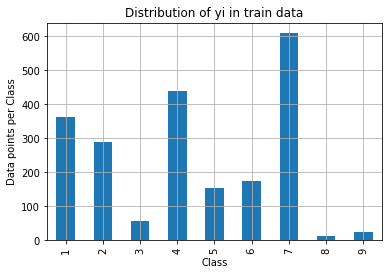

Number of data points in class 7 : 609 ( 28.672 %)
Number of data points in class 4 : 439 ( 20.669 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 2 : 289 ( 13.606 %)
Number of data points in class 6 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 8 : 12 ( 0.565 %)
--------------------------------------------------------------------------------


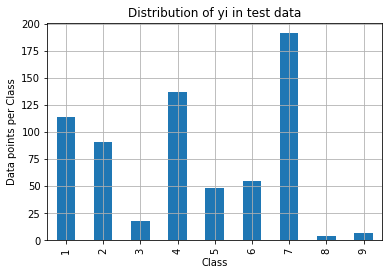

Number of data points in class 7 : 191 ( 28.722 %)
Number of data points in class 4 : 137 ( 20.602 %)
Number of data points in class 1 : 114 ( 17.143 %)
Number of data points in class 2 : 91 ( 13.684 %)
Number of data points in class 6 : 55 ( 8.271 %)
Number of data points in class 5 : 48 ( 7.218 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 9 : 7 ( 1.053 %)
Number of data points in class 8 : 4 ( 0.602 %)
--------------------------------------------------------------------------------


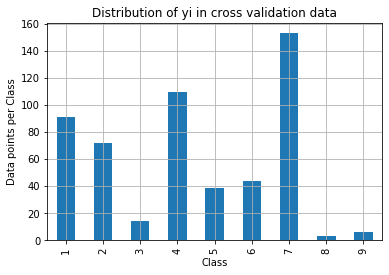

Number of data points in class 7 : 153 ( 28.759 %)
Number of data points in class 4 : 110 ( 20.677 %)
Number of data points in class 1 : 91 ( 17.105 %)
Number of data points in class 2 : 72 ( 13.534 %)
Number of data points in class 6 : 44 ( 8.271 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 3 : 14 ( 2.632 %)
Number of data points in class 9 : 6 ( 1.128 %)
Number of data points in class 8 : 3 ( 0.564 %)


In [11]:
train_class_distribution = train_df['Class'].value_counts().sort_index()
test_class_distribution = test_df['Class'].value_counts().sort_index()
cv_class_distribution = cv_df['Class'].value_counts().sort_index()

my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-train_class_distribution.values)    #'-' sign makes it arrange in desc order
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')
    
print('-'*80)
my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()


sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')

print('-'*80)
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()


sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')


As we can see from these distributions, the dataset in imbalanced

# Predicting using a 'Random' model

(Done to get a baseline log-loss so we know how well we should do from a random model)

In this 'Random model' we generate 9 class probabilities such that they sum to 1

In [12]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

Log loss on Cross Validation Data using Random Model 2.5416058154271544
Log loss on Test Data using Random Model 2.5138386458884128
-------------------- Confusion matrix --------------------


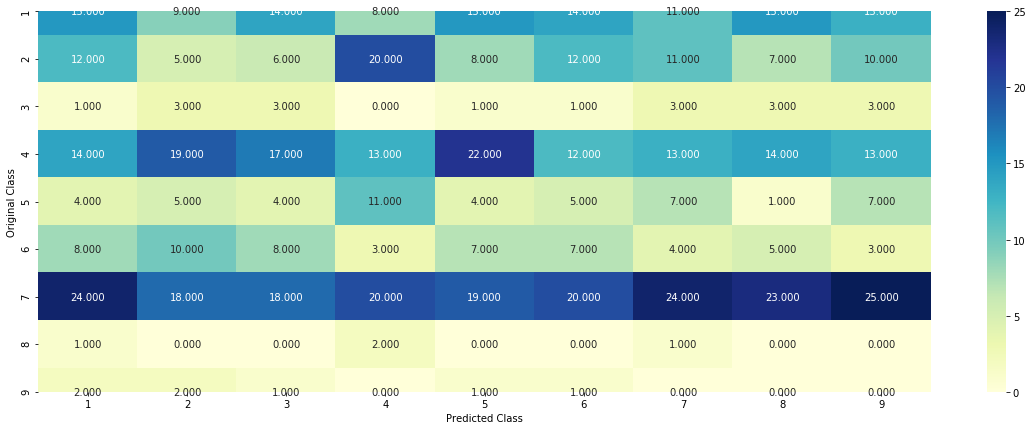

-------------------- Precision matrix (Columm Sum=1) --------------------


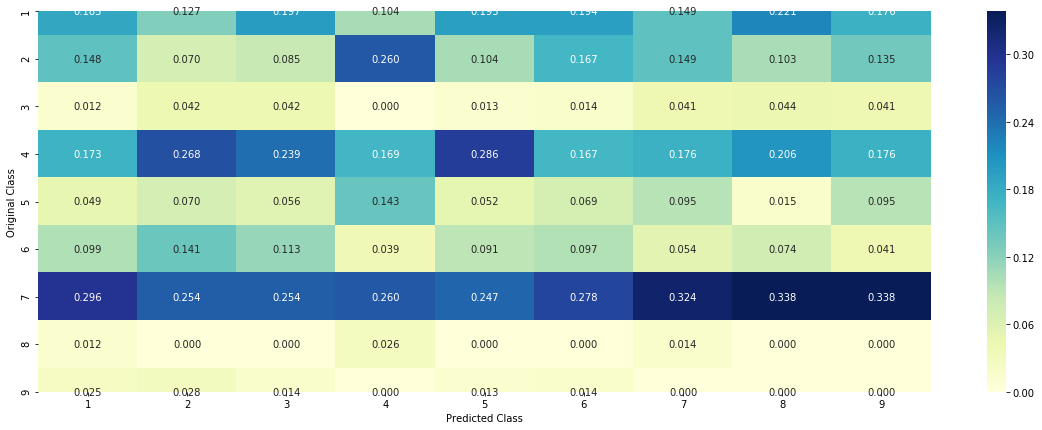

-------------------- Recall matrix (Row sum=1) --------------------


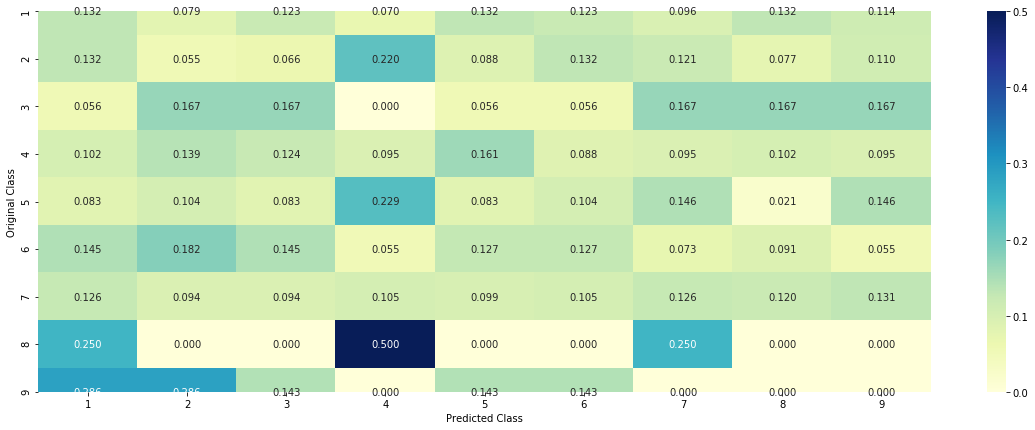

In [13]:
#Here we generate a random number from 1,9 and count that as a prediction for that very datapoint
#Then the log loss is calculated on cv and test data through this random model
#Then this is passed to the confusion matrix function so as to generate a confusion matrix for us to see the results better 
#and get a basic idea on how this model performs

test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

# we create an output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))


# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

predicted_y =np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

As the dataset is imbalanced, we see there are a lot more points on class 7 as there are a lot more datapoints
included in that class

We see that on a random model, our log loss is 2.4. This gives us a good base idea as to how much we shouldl get when using other tecniques(<2.4)

# Univariate Analysis on GENE feature

THE GENE FEATURE

The gene is a categorical feature

In [14]:
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes: ',train_df['Gene'].nunique())
print(unique_genes.head(10))

Number of Unique Genes:  230
BRCA1     170
TP53      104
EGFR       95
BRCA2      82
PTEN       81
KIT        65
BRAF       51
ALK        48
PDGFRA     41
ERBB2      41
Name: Gene, dtype: int64


Laplace smoothing is calculated when we calculate a probability of a particular feature belonging to a particular class

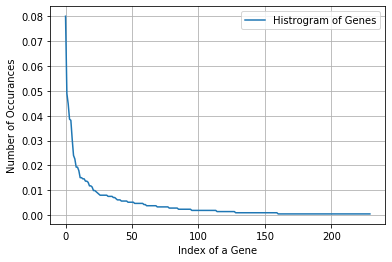

In [15]:
s = sum(unique_genes.values);
h = unique_genes.values/s;
plt.plot(h, label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()


1. This data is a skewed data
2. The first gene occurs almost 8% of the times and as we keep going forward in gene index, the occurances of the genes decrease

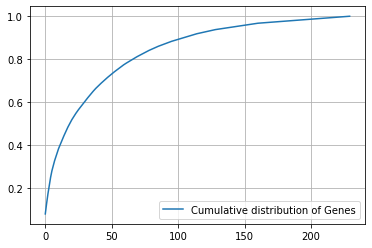

In [16]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

This is the Cumulative distribution of this data
1. We see that the top 50 genes contain almost 75% of the data
2. The other odd 200 genes contain 25% of data
3. Some genes occur way more than others

Since the Gene, Variable feature are categorical, there are a couple of ways to featurize this:
1. One-hot encoding
2. Response coding

RESPONSE CODING

In [17]:
def get_gv_fea_dict(alpha, feature, df):
    
    """
    This function helps compute response coding with laplace smoothing
    Parametres:
    alpha = used for laplace smoothing
    feature = [Gene, Variation]
    df = [train_df, test_df, cv_df]
    
    """
    value_count = train_df[feature].value_counts()
    gv_dict = dict()
    
    for i, denominator in value_count.items():
        vec = []
        for k in range(1,10):
            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = train_df[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
            #gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea
    
    

In [18]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

In [19]:
print('Shape of train data with response coding: ',train_gene_feature_responseCoding.shape)

Shape of train data with response coding:  (2124, 9)


Here, there are 2124 datapoints in our train data and there are 9 classes 

In response coding, the 9 features have probabilities of a particular gene belonging to that class

In [20]:
print('One row of the response coded data looks like this: \n', train_gene_feature_responseCoding[0])

One row of the response coded data looks like this: 
 [0.31958763 0.06185567 0.05670103 0.27319588 0.06185567 0.06701031
 0.05154639 0.05154639 0.05670103]


ONE-HOT ENCODING

In [21]:
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [22]:
print('Shape after One-hot Encoding', train_gene_feature_onehotCoding.shape)

Shape after One-hot Encoding (2124, 229)


Here, there are 2124 datapoints and 235 different genes which are one-hot encoded

One-hot encoding makes a sparse matrix where the feature which is present is makred 1 and others are 0

UNDERSTANDING HOW GOOD IS THE GENE FEATURE

For understanding this, we create a proper ML model by just using this one feature.

Then we get an idea of how important and impactful this feature is

For values of alpha =  1e-05 The log loss is: 1.1757764242147655
For values of alpha =  0.0001 The log loss is: 1.144579455471345
For values of alpha =  0.001 The log loss is: 1.1828467646916654
For values of alpha =  0.01 The log loss is: 1.3096427778937751
For values of alpha =  0.1 The log loss is: 1.4296990757112467
For values of alpha =  1 The log loss is: 1.4739588701168578


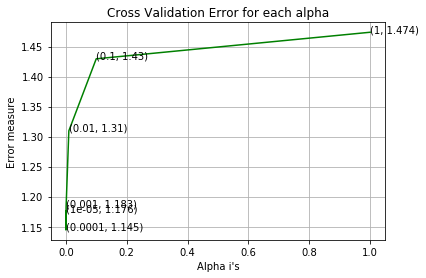

For values of best alpha =  0.0001 The train log loss is: 1.000801788775257
For values of best alpha =  0.0001 The cross validation log loss is: 1.144579455471345
For values of best alpha =  0.0001 The test log loss is: 1.2089548189366635


In [23]:
alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier. We try different alpha values to get best loss
cv_log_error_array = []                 #Array to store all the log loss values after implementing the model

for i in alpha:                         #Trying different vlaues of alpha for best results
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)   #We use one-hotencoding because that works best with logistic regression 
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

    
#Plotting the different log values with different a;pha
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)               #best_alpha stores the index of the alpha which gives min error 
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42) #training the model using that best alpha
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))



Here, the best alpha is 0.0001 as it gives the least loss

we train the model with only Gene feature using this alpha

Here we see that the training error is significantly reduced from that of the random model.
There isnt a lot of difference between training n cv error which helps us understand that our model is not overfitting

# Univariate Analysis on the Variation feature

In [24]:
unique_variations = train_df['Variation'].value_counts()
print('Number of unique variations in training data are: ',train_df['Variation'].nunique())
print(unique_variations.head(10))

Number of unique variations in training data are:  1918
Truncating_Mutations    59
Amplification           53
Deletion                43
Fusions                 26
Overexpression           4
E17K                     3
G12V                     3
T58I                     2
G13C                     2
T73I                     2
Name: Variation, dtype: int64


Here we see that most of the variations dont occur more than 3times in the training data

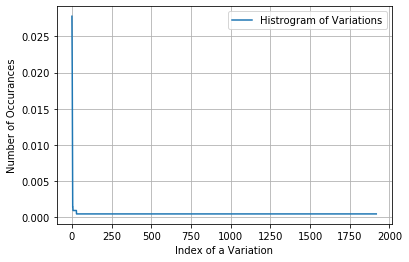

In [25]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
plt.plot(h, label="Histrogram of Variations")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

There is a very steep fall in the number of occurances of variations. This means that there are a lot of different 
categories of variations present and all those variations are not repeated many times

[0.02777778 0.0527307  0.07297552 ... 0.99905838 0.99952919 1.        ]


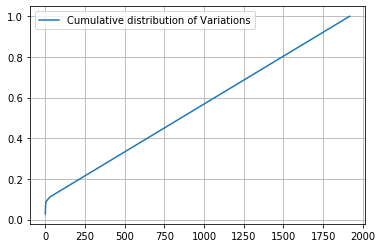

In [26]:
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

Now we featurize Variation by One-hot encoding and response coding

In [27]:
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

In [28]:
print('Shape after laplace smoothing is: ', train_variation_feature_responseCoding.shape)

Shape after laplace smoothing is:  (2124, 9)


In [29]:
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

In [30]:
print('Shape after One-hot encoding is:', train_variation_feature_onehotCoding.shape)

Shape after One-hot encoding is: (2124, 1948)


UNDERSTANDING HOW GOOD IS THE VARIATION FEATURE

For values of alpha =  1e-05 The log loss is: 1.7143351031822678
For values of alpha =  0.0001 The log loss is: 1.7109367564733406
For values of alpha =  0.001 The log loss is: 1.7166805413804858
For values of alpha =  0.01 The log loss is: 1.7331014227812578
For values of alpha =  0.1 The log loss is: 1.743404622743885
For values of alpha =  1 The log loss is: 1.7438481215905273


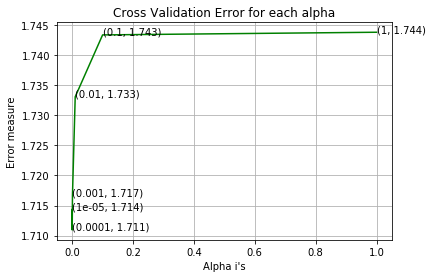

For values of best alpha =  0.0001 The train log loss is: 0.7625937753417816
For values of best alpha =  0.0001 The cross validation log loss is: 1.7109367564733406
For values of best alpha =  0.0001 The test log loss is: 1.7093001323030663


In [31]:
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


We see here that there is a significant difference between the train loss and cv, test loss. We can infer the following:
    
1. This feature is not as stable as the Gene feature because of the number of categories
2. This loss is still significantly less than the loss of the random model
3. so, this feature does add value to our problem but it is a little unstable

# Univariate analysis on the 'text' feature

In [32]:
# cls_text is a data frame
# for every row in data fram consider the 'TEXT'
# split the words by space
# make a dict with those words
# increment its count whenever we see that word

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [33]:
import math
#function that implements response coding for the text feature
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [34]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 54058


In [35]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [36]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [37]:
# https://stackoverflow.com/a/16202486
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [38]:
# Normalizing the features
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [39]:
#https://stackoverflow.com/a/2258273/4084039
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [40]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur)) #Number of times a word occurs:no of words that occur

Counter({3: 5513, 4: 3752, 6: 2919, 5: 2742, 7: 2153, 8: 2082, 9: 1822, 10: 1504, 12: 1323, 11: 1055, 15: 1039, 16: 881, 14: 848, 13: 805, 20: 760, 18: 697, 17: 686, 24: 542, 19: 505, 21: 480, 22: 473, 30: 444, 37: 390, 27: 377, 23: 370, 28: 351, 26: 347, 25: 338, 29: 333, 32: 322, 36: 283, 31: 266, 33: 256, 49: 253, 34: 243, 42: 240, 35: 228, 40: 219, 48: 205, 38: 199, 39: 188, 43: 185, 46: 177, 50: 174, 45: 174, 41: 174, 44: 168, 60: 166, 54: 157, 57: 155, 47: 147, 51: 139, 56: 137, 52: 137, 55: 128, 53: 126, 64: 122, 63: 122, 58: 122, 59: 118, 65: 117, 62: 114, 84: 112, 61: 112, 66: 106, 67: 103, 72: 98, 70: 98, 69: 98, 68: 97, 71: 92, 80: 89, 76: 87, 75: 87, 81: 86, 74: 86, 73: 85, 82: 81, 78: 77, 77: 77, 98: 74, 88: 74, 86: 72, 85: 70, 94: 69, 90: 69, 87: 69, 91: 68, 79: 64, 118: 60, 83: 60, 92: 59, 89: 58, 95: 57, 102: 56, 100: 56, 96: 56, 108: 55, 110: 54, 97: 54, 103: 53, 111: 52, 114: 51, 126: 50, 115: 49, 99: 49, 121: 48, 116: 48, 120: 46, 119: 46, 112: 46, 105: 45, 104: 45, 

For values of alpha =  1e-05 The log loss is: 1.3127040923491702
For values of alpha =  0.0001 The log loss is: 1.176431304681171
For values of alpha =  0.001 The log loss is: 1.1567601783792505
For values of alpha =  0.01 The log loss is: 1.2677034916827297
For values of alpha =  0.1 The log loss is: 1.4042475037591788
For values of alpha =  1 The log loss is: 1.614120251109825


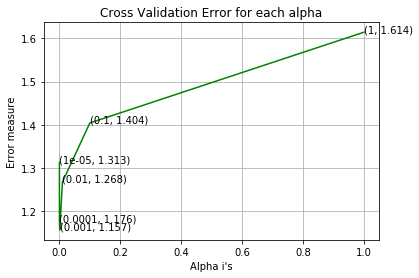

For values of best alpha =  0.001 The train log loss is: 0.6945087521805104
For values of best alpha =  0.001 The cross validation log loss is: 1.1567601783792505
For values of best alpha =  0.001 The test log loss is: 1.1637640684405288


In [41]:
# Train a Logistic regression+Calibration model using text features which are on-hot encoded
alpha = [10 ** x for x in range(-5, 1)]


cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


The text feature alone gives us good log loss and this is way less than the variation loss

We can conclude that this is also a very important feature

# Machine Learning Models

Writing some misc functions that will help in execution of the ML models

In [42]:
def predict_and_plot_confusion_matrix(train_x, train_y, test_x, test_y, clf):
    """
    This function helps plot the 3 confusion matrix that were plotted before
    This way we can compare and contrast many models after training n predicting on them
    """
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [43]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [44]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

DATA PREPARATION

In [45]:
#Merging the Gene, variation and text features
#hstack() is used to merge the features
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr() #tocsr converts to compressed sparse matrix form 
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))


train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))

In [46]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 56235)
(number of data points * number of features) in test data =  (665, 56235)
(number of data points * number of features) in cross validation data = (532, 56235)


In [47]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


We see that obviously one-hotencoding will have way more features than Response coding

We are preserving both of these featurizations because models like Naive bayes, KNN, Decision trees cannot handle 
large number of features(Curse od simentionality) and the will be fed with response coding featurizations

Models like SVMs, Logistic regression etc can work with high featurizations and so they can be fed one-hotencoding

# BASE LINE MODELS

# 1. Naive Bayes

For alpha: 1e-05
Log Loss : 1.2788361992677546
For alpha: 0.0001
Log Loss : 1.2817090981203554
For alpha: 0.001
Log Loss : 1.2756001461883502
For alpha: 0.01
Log Loss : 1.280357951967935
For alpha: 0.1
Log Loss : 1.257645530708661
For alpha: 1
Log Loss : 1.316511946612379
For alpha: 10
Log Loss : 1.4150340083765327
For alpha: 100
Log Loss : 1.3941564485472453


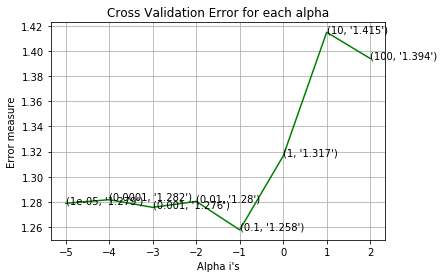

For values of best alpha =  0.1 The train log loss is: 0.8769817934857581
For values of best alpha =  0.1 The cross validation log loss is: 1.257645530708661
For values of best alpha =  0.1 The test log loss is: 1.2699065631464515


In [48]:
#We use multi dimentional naive bayes since we have multiple classes
alpha = [0.00001, 0.0001, 0.001, 0.01,0.1, 1, 10, 100]
cv_log_error_array = []

for i in alpha:
    print('For alpha:', i)
    clf = MultinomialNB(alpha = i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method = 'sigmoid')
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs))
    
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

    

Naive bayes isnt as powerful a model as logistic regression. Thats why we notice that while doing univariate analysis 
using logistic regression, we got better results with the text feature only
Naive bayes here acts as a good baseline model since it works well with text data.

Log Loss : 1.257645530708661
Number of missclassified point : 0.4041353383458647
-------------------- Confusion matrix --------------------


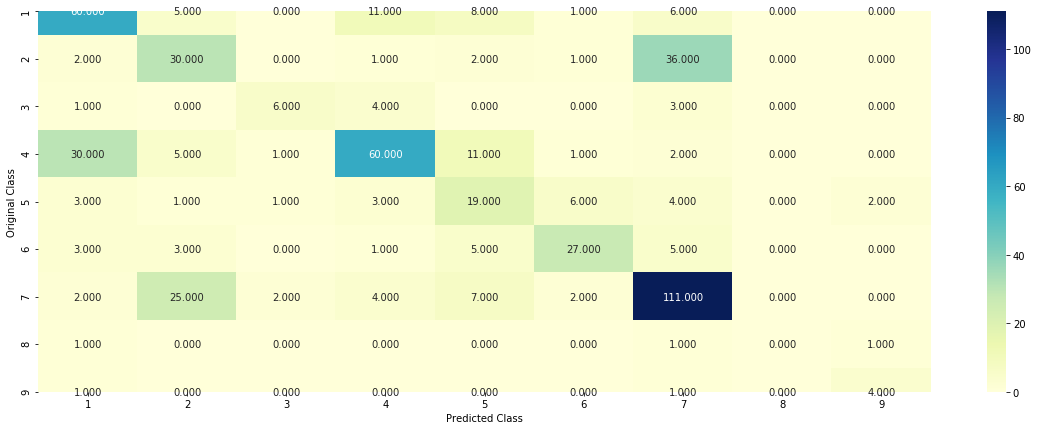

-------------------- Precision matrix (Columm Sum=1) --------------------


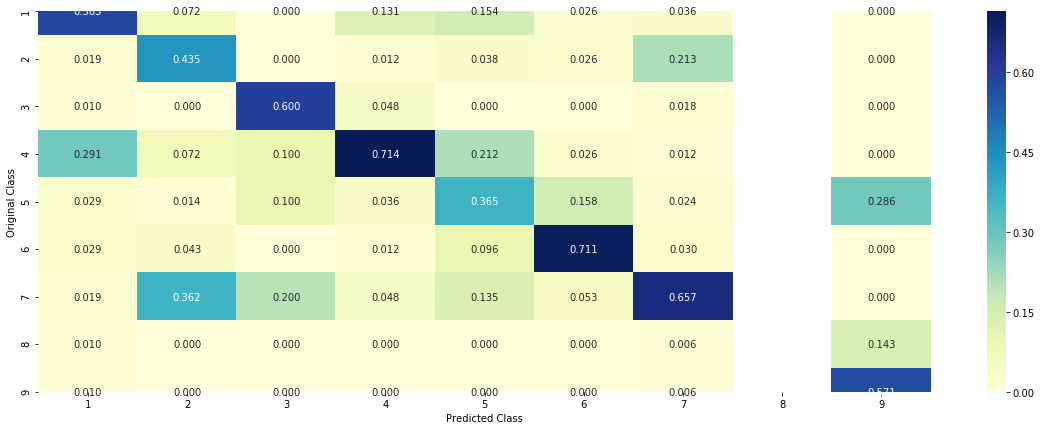

-------------------- Recall matrix (Row sum=1) --------------------


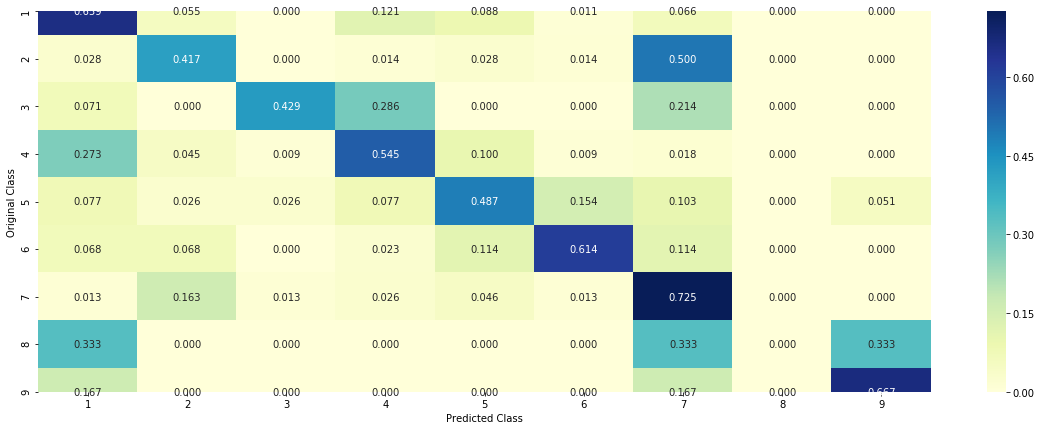

In [49]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0]) #count_nonzero counts the number of points that are non-zero. This helps us getting to know the misclassifyed points
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))


Its hard to interpret the result properly from the confusion matrix since class 7 contains a lot of points.

This is why we use the Precision and recall matrix, so that we get a better understanding

There are some specific classes that are getting mistaken for the other. Eg.
2-7
4-1

TESTING OUTPUTS: CORRECTLY CLASSIFYED

In [50]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices=np.argsort(-1*abs(clf.coef_))[predicted_cls][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.0698 0.0641 0.0146 0.6594 0.0368 0.0321 0.117  0.0035 0.0027]]
Actual Class : 4
--------------------------------------------------
Out of the top  100  features  0 are present in query point


In [51]:
test_point_index = 101
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.2441 0.0707 0.016  0.1017 0.0405 0.0355 0.4847 0.0038 0.0029]]
Actual Class : 4
--------------------------------------------------
Out of the top  100  features  0 are present in query point


We get interpretability here as our model shows the words present in the literature which enables it to give the output
This helps the medical professional not blindly accept the model but gives some confidence behind it

# 2. K-Nearnest Neighbours Classification

for alpha = 5
Log Loss : 1.0507004592772462
for alpha = 11
Log Loss : 1.0493130012935663
for alpha = 15
Log Loss : 1.0655497717472433
for alpha = 21
Log Loss : 1.0860587011530558
for alpha = 31
Log Loss : 1.0989636817246302
for alpha = 41
Log Loss : 1.1054955481392468
for alpha = 51
Log Loss : 1.116908339959013
for alpha = 99
Log Loss : 1.1267113711262962


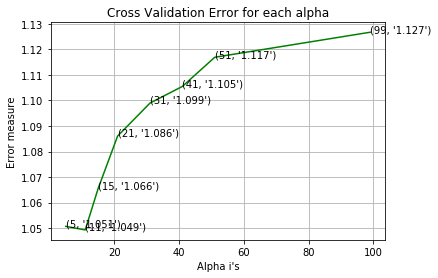

For values of best alpha =  11 The train log loss is: 0.6338855457796427
For values of best alpha =  11 The cross validation log loss is: 1.0493130012935663
For values of best alpha =  11 The test log loss is: 1.1102192543842702


In [52]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]  #Hyperparameter selection
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


Log loss : 1.0493130012935663
Number of mis-classified points : 0.34962406015037595
-------------------- Confusion matrix --------------------


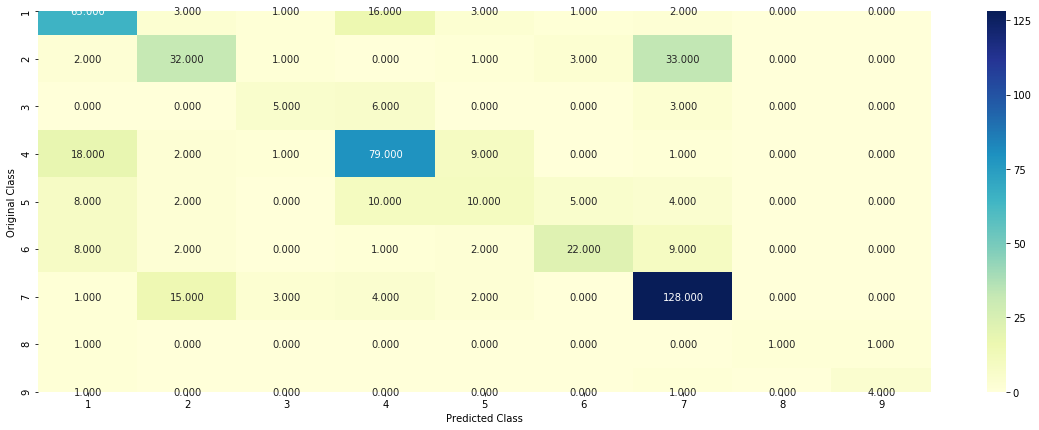

-------------------- Precision matrix (Columm Sum=1) --------------------


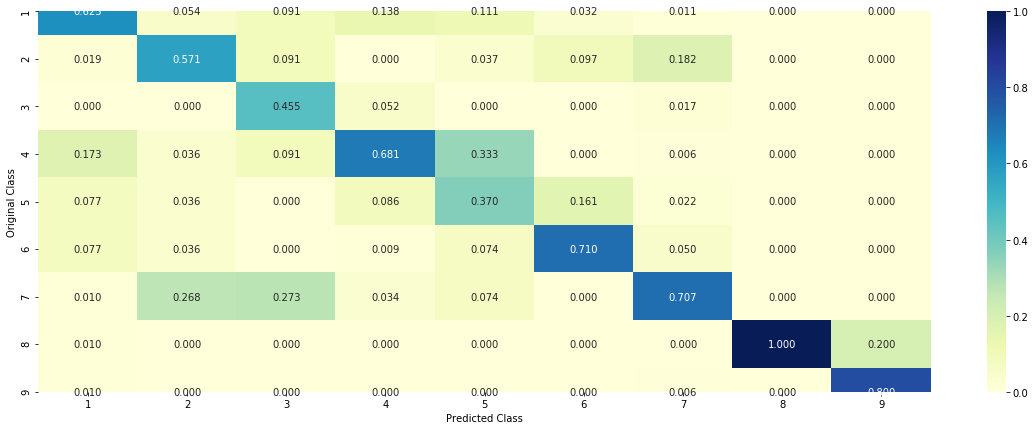

-------------------- Recall matrix (Row sum=1) --------------------


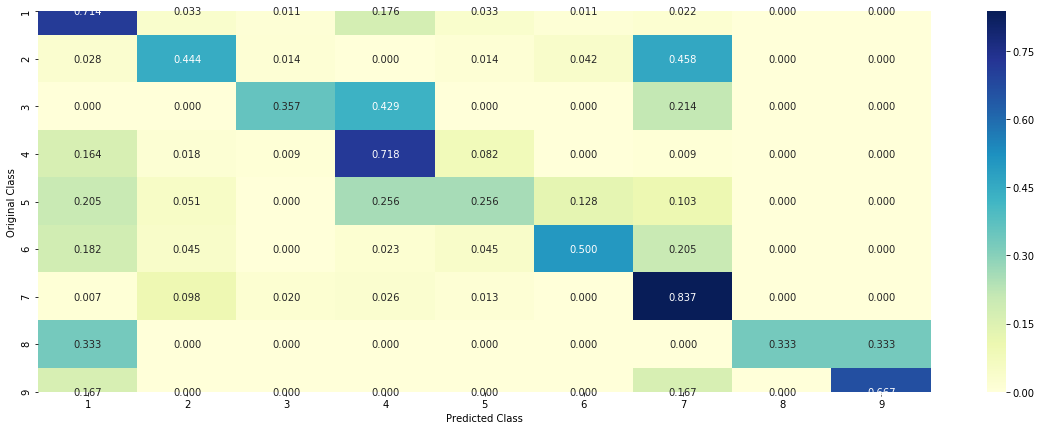

In [53]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

#Response coded features are used as KNN cannot handle high dimention caused due to one-hot encoding

It's good to see that even though class 8,9 contain very few points, theyre correctlty classified

We can see here that the KNN classifier does a good job at predicting the correct classes except for some reason,
it gets the class 3 mistaken for class 4,7 a lot

TESTING OUTPUT ON TEST QUERY

In [54]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 7
Actual Class : 4
The  11  nearest neighbours of the test points belongs to classes [4 4 4 4 4 4 4 4 4 4 4]
Fequency of nearest points : Counter({4: 11})


In [55]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 100

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 6
Actual Class : 6
the k value for knn is 11 and the nearest neighbours of the test points belongs to classes [6 6 6 6 6 6 6 6 6 6 6]
Fequency of nearest points : Counter({6: 11})


We can see the interpretability here as the sourrounding classes are seen thus showing us how confident the model is
in giving the output
KNN doesnt give good interpretability

# Logistic Regression(Class balancing)

for alpha = 1e-06
Log Loss : 1.333889263596024
for alpha = 1e-05
Log Loss : 1.327371424838963
for alpha = 0.0001
Log Loss : 1.137754025354295
for alpha = 0.001
Log Loss : 1.0925475010630645
for alpha = 0.01
Log Loss : 1.1726169999189893
for alpha = 0.1
Log Loss : 1.4503700333524787
for alpha = 1
Log Loss : 1.6913737427775826
for alpha = 10
Log Loss : 1.7206491574434692
for alpha = 100
Log Loss : 1.7235293524965776


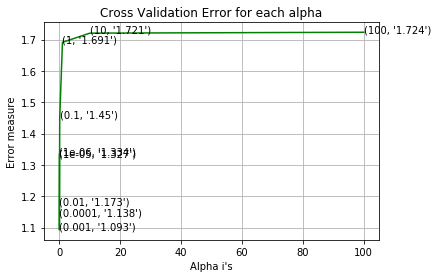

For values of best alpha =  0.001 The train log loss is: 0.5561454981133332
For values of best alpha =  0.001 The cross validation log loss is: 1.0925475010630645
For values of best alpha =  0.001 The test log loss is: 1.1044797440741219


In [56]:
alpha = [10 ** x for x in range(-6, 3)]  #Hyperparametre selection
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.0925475010630645
Number of mis-classified points : 0.35150375939849626
-------------------- Confusion matrix --------------------


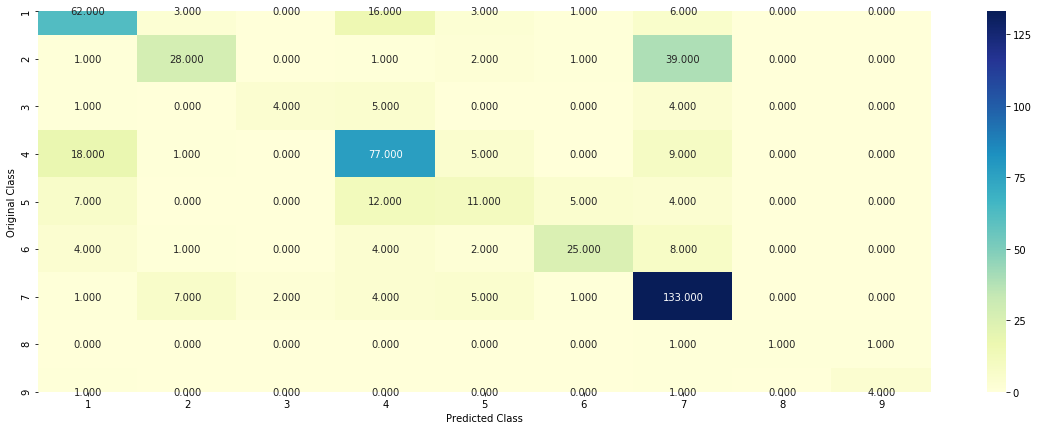

-------------------- Precision matrix (Columm Sum=1) --------------------


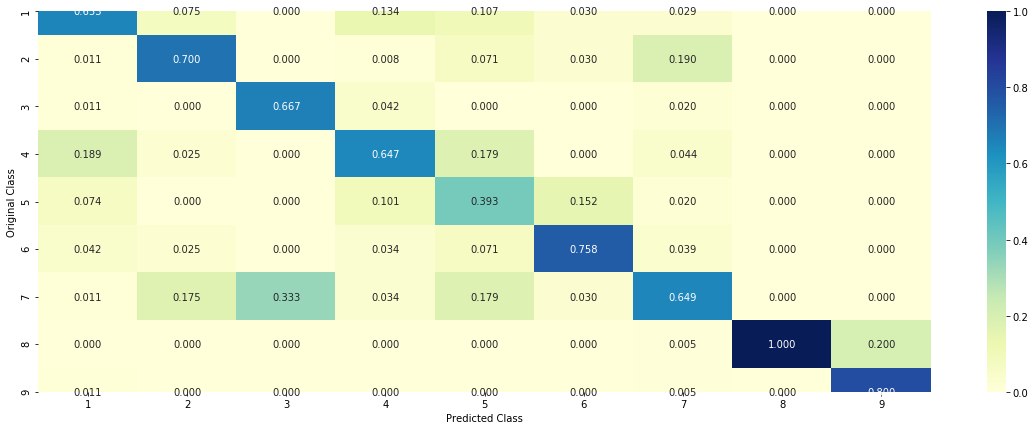

-------------------- Recall matrix (Row sum=1) --------------------


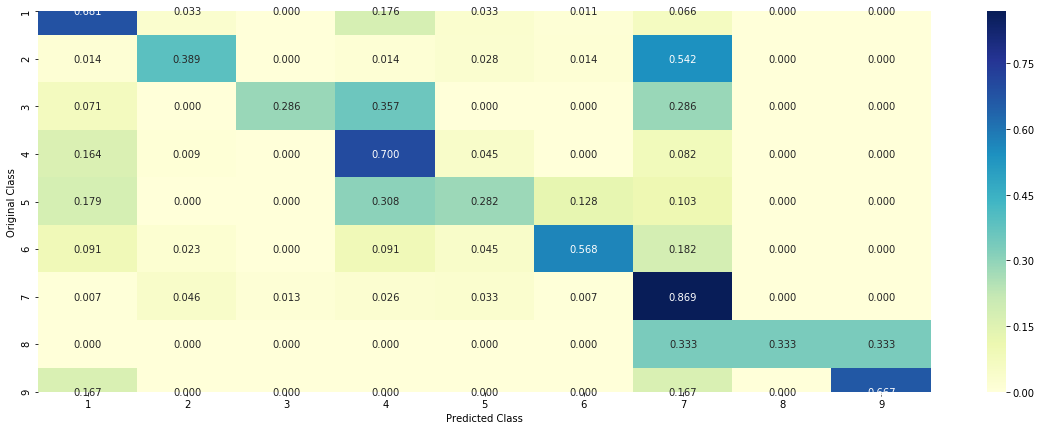

In [57]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

As the logistic regression is a very powerful model, we can see the good results

TESTING OUTPUT ON TEST DATA

In [58]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

In [59]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.0069 0.0208 0.0467 0.8921 0.0122 0.0052 0.0104 0.0032 0.0025]]
Actual Class : 4
--------------------------------------------------
217 Text feature [harboring] present in test data point [True]
298 Text feature [concentrations] present in test data point [True]
319 Text feature [kinase] present in test data point [True]
358 Text feature [copurified] present in test data point [True]
389 Text feature [suppressor] present in test data point [True]
Out of the top  500  features  5 are present in query point


In [60]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 6
Predicted Class Probabilities: [[0.0038 0.0117 0.0037 0.0785 0.007  0.8849 0.0062 0.0029 0.0014]]
Actual Class : 6
--------------------------------------------------
207 Text feature [2b] present in test data point [True]
211 Text feature [tagged] present in test data point [True]
234 Text feature [leaves] present in test data point [True]
272 Text feature [3b] present in test data point [True]
282 Text feature [mutants] present in test data point [True]
307 Text feature [3a] present in test data point [True]
324 Text feature [encoding] present in test data point [True]
363 Text feature [s80] present in test data point [True]
374 Text feature [expressing] present in test data point [True]
387 Text feature [2a] present in test data point [True]
388 Text feature [results] present in test data point [True]
399 Text feature [weakened] present in test data point [True]
401 Text feature [nih] present in test data point [True]
425 Text feature [author] present in test data

Again, we see the interpretability of the model showing what text is present in the literature which helped the model give
the output it gave. This helps the medical professionals get confidence in the same

# Logistic Regression(Without class balancing)

for alpha = 1e-06
Log Loss : 1.3196058411801568
for alpha = 1e-05
Log Loss : 1.3056622646227978
for alpha = 0.0001
Log Loss : 1.1236836090103917
for alpha = 0.001
Log Loss : 1.1074363120624608
for alpha = 0.01
Log Loss : 1.2230493594386163
for alpha = 0.1
Log Loss : 1.3483068489110506
for alpha = 1
Log Loss : 1.5551928850567918


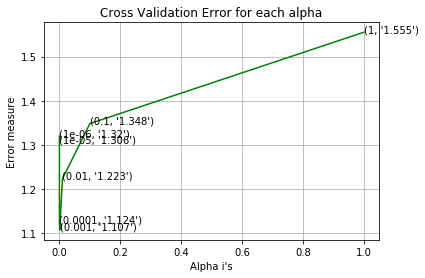

For values of best alpha =  0.001 The train log loss is: 0.5535004811901861
For values of best alpha =  0.001 The cross validation log loss is: 1.1074363120624608
For values of best alpha =  0.001 The test log loss is: 1.1186097867924443


In [61]:
alpha = [10 ** x for x in range(-6, 1)]  #Hyperparameter selection
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.1074363120624608
Number of mis-classified points : 0.34962406015037595
-------------------- Confusion matrix --------------------


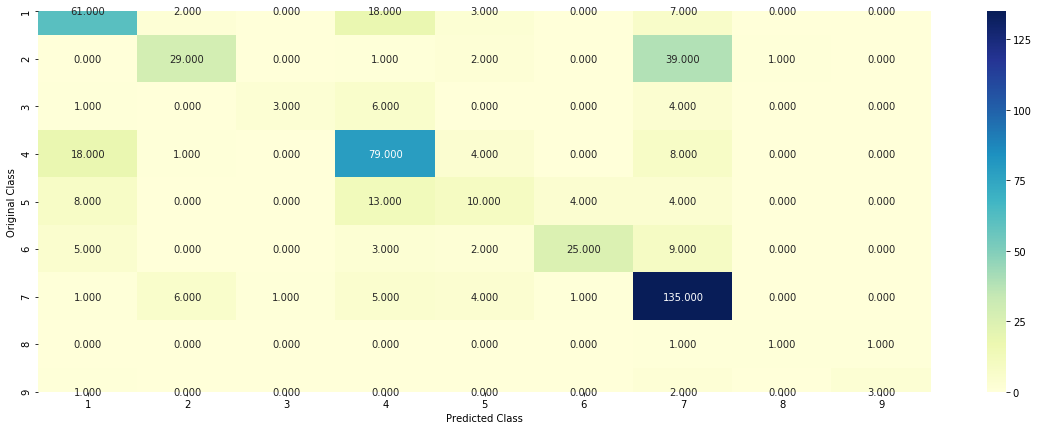

-------------------- Precision matrix (Columm Sum=1) --------------------


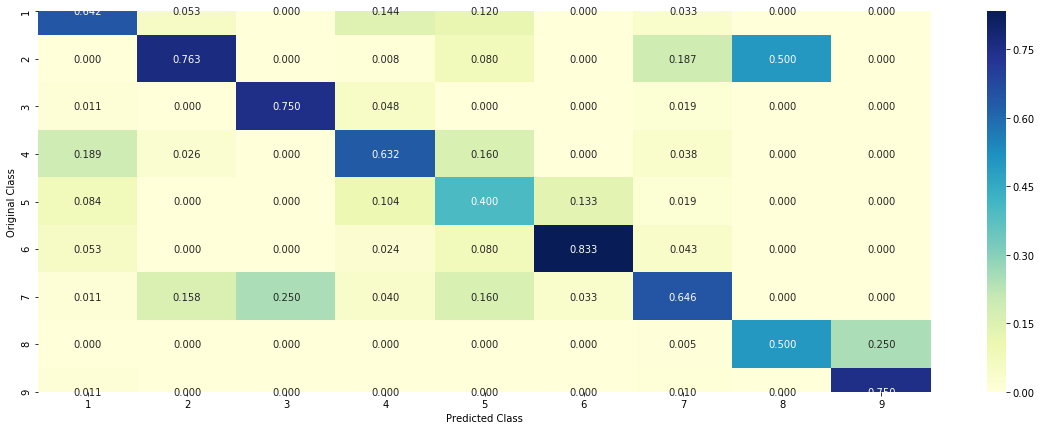

-------------------- Recall matrix (Row sum=1) --------------------


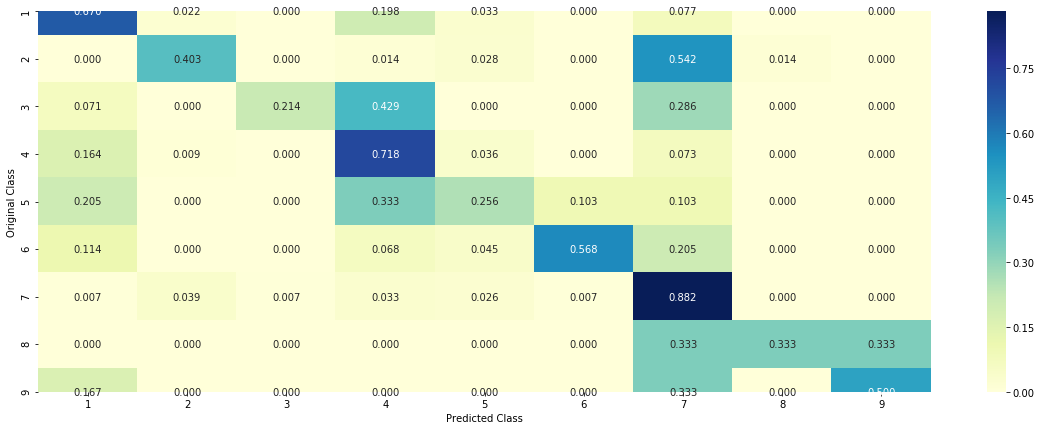

In [62]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [63]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[7.700e-03 2.220e-02 2.060e-02 9.184e-01 1.220e-02 5.200e-03 1.060e-02
  2.500e-03 5.000e-04]]
Actual Class : 4
--------------------------------------------------
335 Text feature [harboring] present in test data point [True]
394 Text feature [copurified] present in test data point [True]
466 Text feature [concentrations] present in test data point [True]
487 Text feature [suppressor] present in test data point [True]
Out of the top  500  features  4 are present in query point


In [64]:
test_point_index = 2
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0744 0.1871 0.0366 0.0875 0.0773 0.05   0.4693 0.0069 0.011 ]]
Actual Class : 2
--------------------------------------------------
213 Text feature [constitutively] present in test data point [True]
220 Text feature [activating] present in test data point [True]
230 Text feature [activated] present in test data point [True]
264 Text feature [expressing] present in test data point [True]
334 Text feature [activation] present in test data point [True]
414 Text feature [receptor] present in test data point [True]
495 Text feature [inhibited] present in test data point [True]
Out of the top  500  features  7 are present in query point


We notice here that the overall loss and misclasification rate is less with class balancing.
LR without class balancing helps classify the minor classes well

# Support Vector Machines

for C = 1e-05
Log Loss : 1.3185362736829331
for C = 0.0001
Log Loss : 1.2427768993700061
for C = 0.001
Log Loss : 1.1049775664402914
for C = 0.01
Log Loss : 1.113817434174119
for C = 0.1
Log Loss : 1.3927295456198465
for C = 1
Log Loss : 1.7085350626961393
for C = 10
Log Loss : 1.7238447730668884
for C = 100
Log Loss : 1.723844813536447


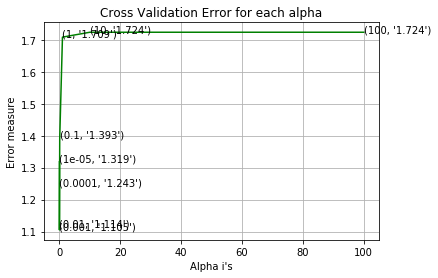

For values of best alpha =  0.001 The train log loss is: 0.5700751851514012
For values of best alpha =  0.001 The cross validation log loss is: 1.1049775664402914
For values of best alpha =  0.001 The test log loss is: 1.1724401908532205


In [65]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.1049775664402914
Number of mis-classified points : 0.34398496240601506
-------------------- Confusion matrix --------------------


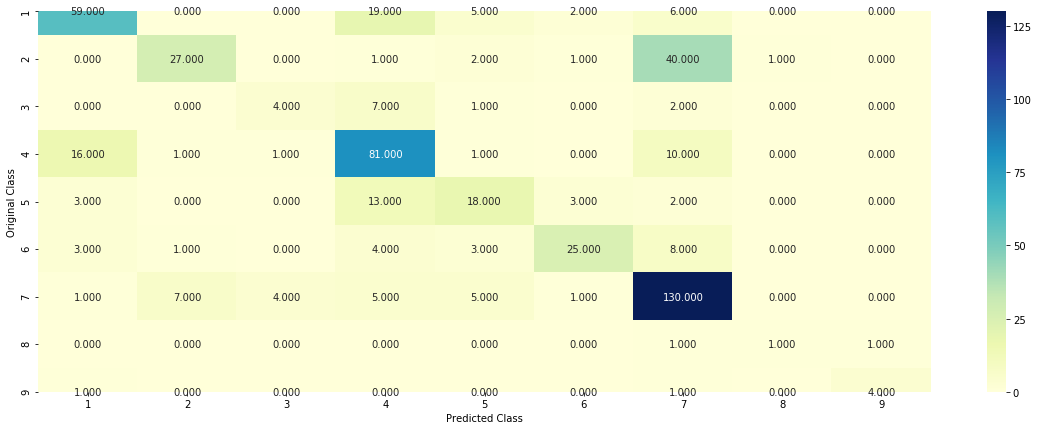

-------------------- Precision matrix (Columm Sum=1) --------------------


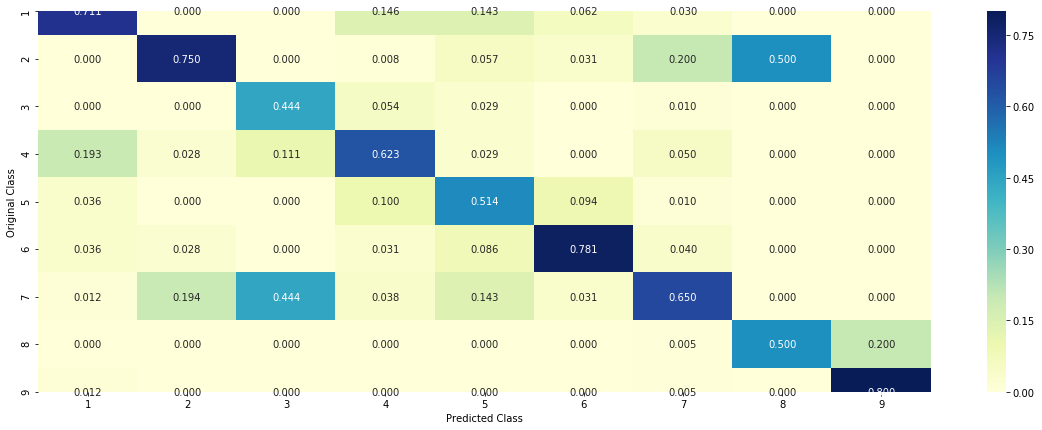

-------------------- Recall matrix (Row sum=1) --------------------


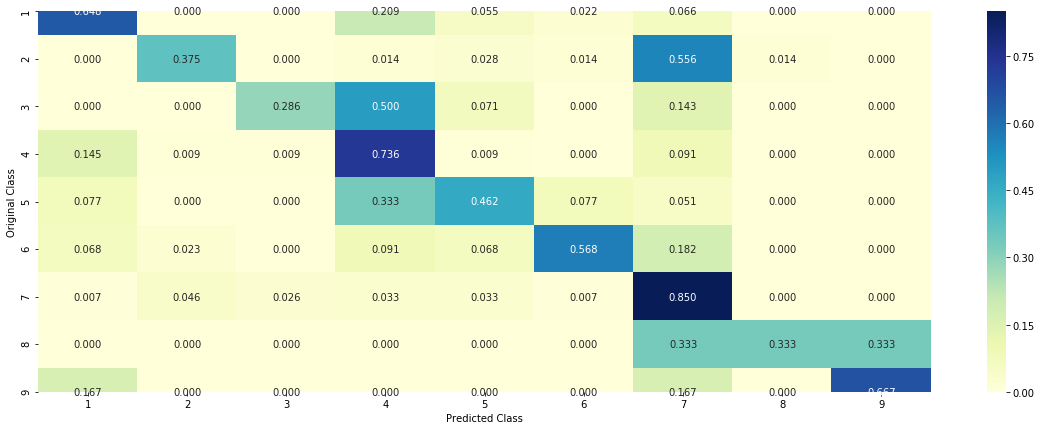

In [66]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

TESTING OUTPUT ON TEST DATA

In [67]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
# test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.0485 0.0677 0.0282 0.7584 0.0299 0.0173 0.0404 0.0041 0.0055]]
Actual Class : 4
--------------------------------------------------
384 Text feature [endometrial] present in test data point [True]
Out of the top  500  features  1 are present in query point


In [68]:
test_point_index = 2
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0897 0.21   0.0275 0.0964 0.0681 0.0437 0.4504 0.006  0.0081]]
Actual Class : 2
--------------------------------------------------
Out of the top  500  features  0 are present in query point


# Random Forest classifier - OneHot encoding

In [69]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

'''fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/2)],max_depth[int(i%2)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
'''

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 1.257249315925074
for n_estimators = 100 and max depth =  10
Log Loss : 1.2004192439331742
for n_estimators = 200 and max depth =  5
Log Loss : 1.2429674221135543
for n_estimators = 200 and max depth =  10
Log Loss : 1.183719856110791
for n_estimators = 500 and max depth =  5
Log Loss : 1.2388147154077411
for n_estimators = 500 and max depth =  10
Log Loss : 1.1729502310431057
for n_estimators = 1000 and max depth =  5
Log Loss : 1.2390037889619419
for n_estimators = 1000 and max depth =  10
Log Loss : 1.1691767649597562
for n_estimators = 2000 and max depth =  5
Log Loss : 1.2392593554533453
for n_estimators = 2000 and max depth =  10
Log Loss : 1.1665608856757
For values of best estimator =  2000 The train log loss is: 0.6905920292660885
For values of best estimator =  2000 The cross validation log loss is: 1.1665608856757
For values of best estimator =  2000 The test log loss is: 1.1780755611847196


Log loss : 1.1665608856757
Number of mis-classified points : 0.38533834586466165
-------------------- Confusion matrix --------------------


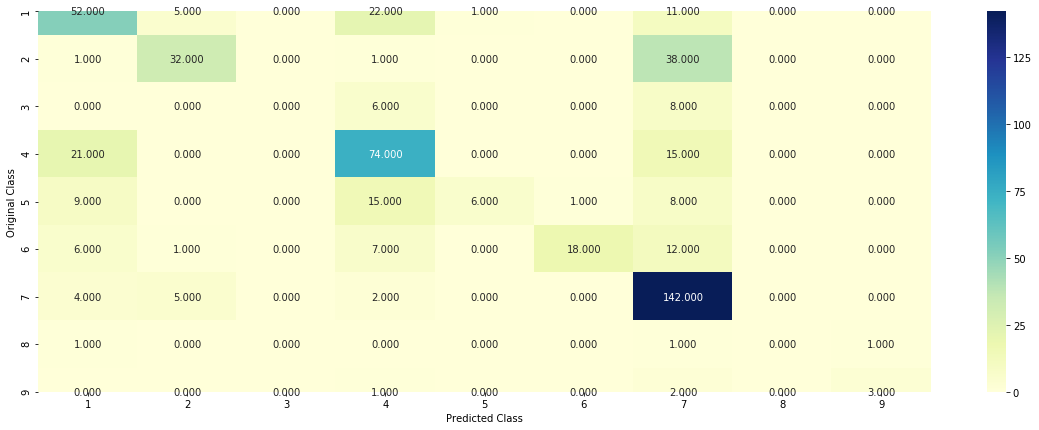

-------------------- Precision matrix (Columm Sum=1) --------------------


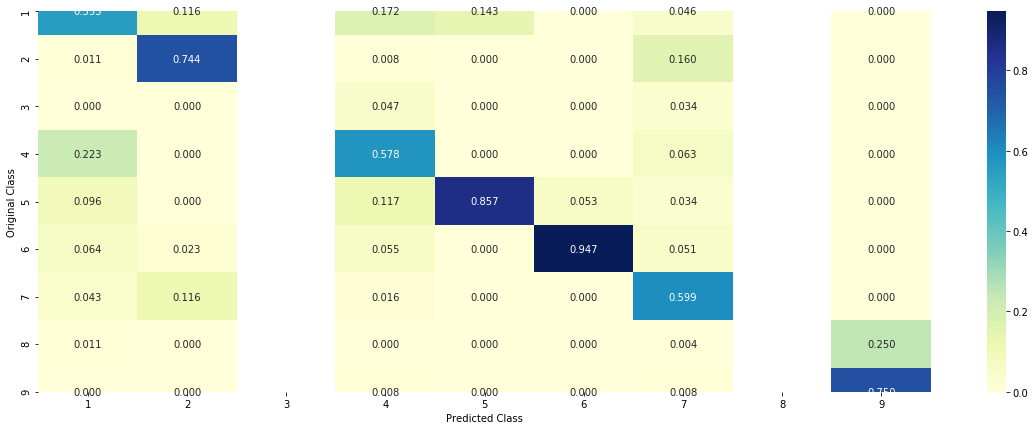

-------------------- Recall matrix (Row sum=1) --------------------


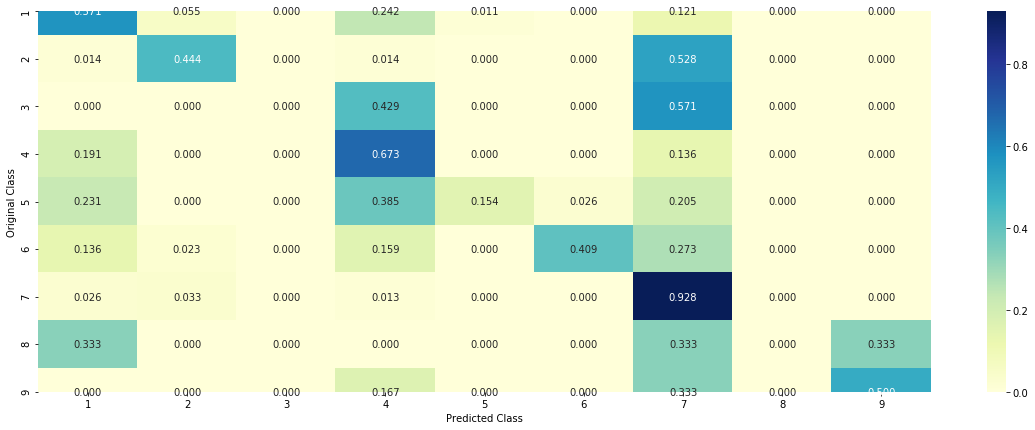

In [70]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

TESTING ON TEST DATA

In [71]:
# test_point_index = 10
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.0461 0.0157 0.0203 0.8404 0.031  0.0227 0.017  0.0049 0.0019]]
Actual Class : 4
--------------------------------------------------
0 Text feature [kinase] present in test data point [True]
2 Text feature [tyrosine] present in test data point [True]
3 Text feature [phosphorylation] present in test data point [True]
7 Text feature [nonsense] present in test data point [True]
10 Text feature [missense] present in test data point [True]
11 Text feature [suppressor] present in test data point [True]
16 Text feature [function] present in test data point [True]
17 Text feature [signaling] present in test data point [True]
19 Text feature [akt] present in test data point [True]
20 Text feature [downstream] present in test data point [True]
24 Text feature [cells] present in test data point [True]
26 Text feature [growth] present in test data point [True]
28 Text feature [functional] present in test data point [True]
29 Text feature [loss] 

In [72]:
test_point_index = 2
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actuall Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0668 0.2423 0.0245 0.0482 0.0485 0.0418 0.5183 0.0059 0.0038]]
Actuall Class : 2
--------------------------------------------------
0 Text feature [kinase] present in test data point [True]
1 Text feature [activating] present in test data point [True]
2 Text feature [tyrosine] present in test data point [True]
3 Text feature [phosphorylation] present in test data point [True]
4 Text feature [inhibitors] present in test data point [True]
5 Text feature [activation] present in test data point [True]
6 Text feature [inhibitor] present in test data point [True]
8 Text feature [oncogenic] present in test data point [True]
9 Text feature [activated] present in test data point [True]
14 Text feature [treatment] present in test data point [True]
15 Text feature [constitutively] present in test data point [True]
17 Text feature [signaling] present in test data point [True]
18 Text feature [trials] present in test data point [True]
24 Text f

We can see that the model gives us better interpretability

Random forest gives us good precision on minor classes ut bad recall

# Random forest - response coding

In [73]:
alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 
'''
fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/4)],max_depth[int(i%4)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
'''

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 10 and max depth =  2
Log Loss : 2.1093881512740893
for n_estimators = 10 and max depth =  3
Log Loss : 1.6545105967808535
for n_estimators = 10 and max depth =  5
Log Loss : 1.3983714046464624
for n_estimators = 10 and max depth =  10
Log Loss : 1.6352059208991097
for n_estimators = 50 and max depth =  2
Log Loss : 1.767753064184987
for n_estimators = 50 and max depth =  3
Log Loss : 1.4941791041682124
for n_estimators = 50 and max depth =  5
Log Loss : 1.3427285483948097
for n_estimators = 50 and max depth =  10
Log Loss : 1.5953167639164094
for n_estimators = 100 and max depth =  2
Log Loss : 1.591010311565871
for n_estimators = 100 and max depth =  3
Log Loss : 1.5167976584178031
for n_estimators = 100 and max depth =  5
Log Loss : 1.3697867781236088
for n_estimators = 100 and max depth =  10
Log Loss : 1.627127753326041
for n_estimators = 200 and max depth =  2
Log Loss : 1.7031052850734638
for n_estimators = 200 and max depth =  3
Log Loss : 1.5561053255020085


Log loss : 1.3427285483948097
Number of mis-classified points : 0.4755639097744361
-------------------- Confusion matrix --------------------


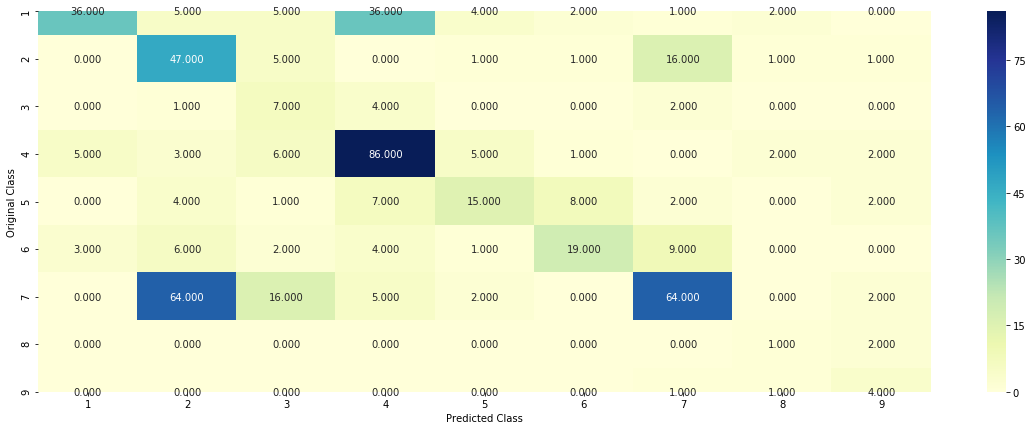

-------------------- Precision matrix (Columm Sum=1) --------------------


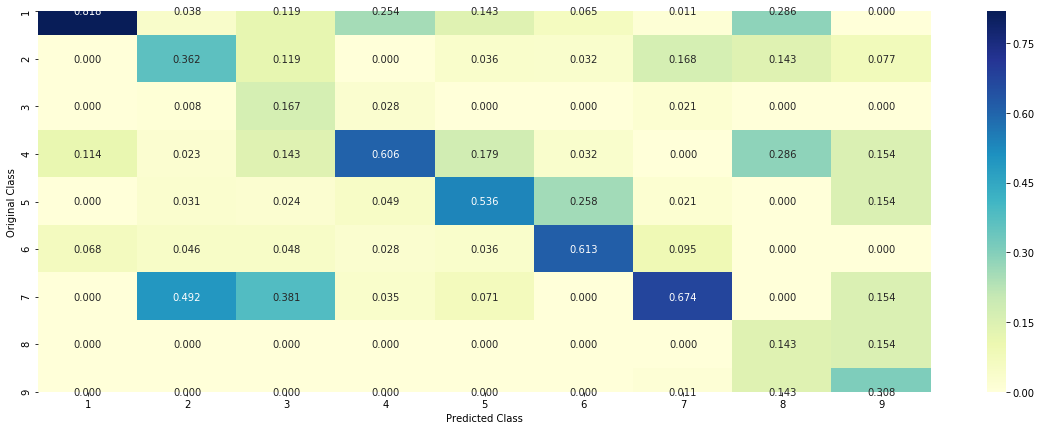

-------------------- Recall matrix (Row sum=1) --------------------


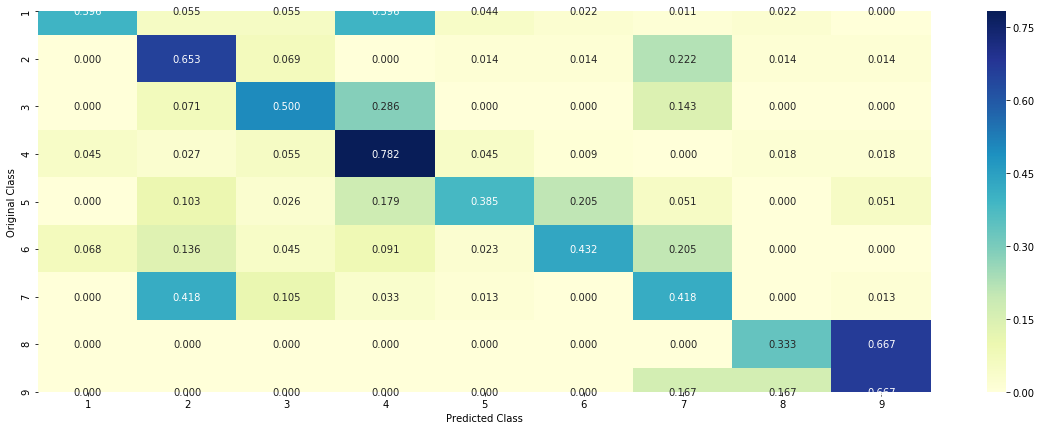

In [74]:
clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_features='auto',random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y, clf)

TESTING ON A TEST POINT

In [75]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)


test_point_index = 1
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 4
Predicted Class Probabilities: [[2.200e-03 1.300e-03 1.700e-03 9.867e-01 8.000e-04 2.700e-03 1.300e-03
  1.700e-03 1.600e-03]]
Actual Class : 4
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Gene is important feature
Gene is important feature
Text is important feature
Text is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Gene is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature


In [76]:
test_point_index = 100
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 6
Predicted Class Probabilities: [[0.0084 0.003  0.0834 0.0127 0.0753 0.8094 0.0018 0.0031 0.0029]]
Actual Class : 6
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Gene is important feature
Gene is important feature
Text is important feature
Text is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Gene is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature


Random forest with response coding overfit the data as seen from the difference between training error and CV error

This probably happened because response coding had significantly less dimensions than one-hot encoding so it was easy 
to overfit 

# Stacking the Models

Here, we're stacking the ML models which gave us the best results and then we will be classifying based on the majyority 
voting process

The ML models being stacked are:
1. Logistic Regression
2. SVM
3. Naive Bayes

This is then put through a Logistic Regression model 

In [77]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.11
Support vector machines : Log Loss: 1.71
Naive Bayes : Log Loss: 1.28
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.178
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.039
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.528
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.145
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.244
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.537


Log loss (train) on the stacking classifier : 0.6444065996351139
Log loss (CV) on the stacking classifier : 1.1445656915024867
Log loss (test) on the stacking classifier : 1.1515301476491298
Number of missclassified point : 0.36541353383458647
-------------------- Confusion matrix --------------------


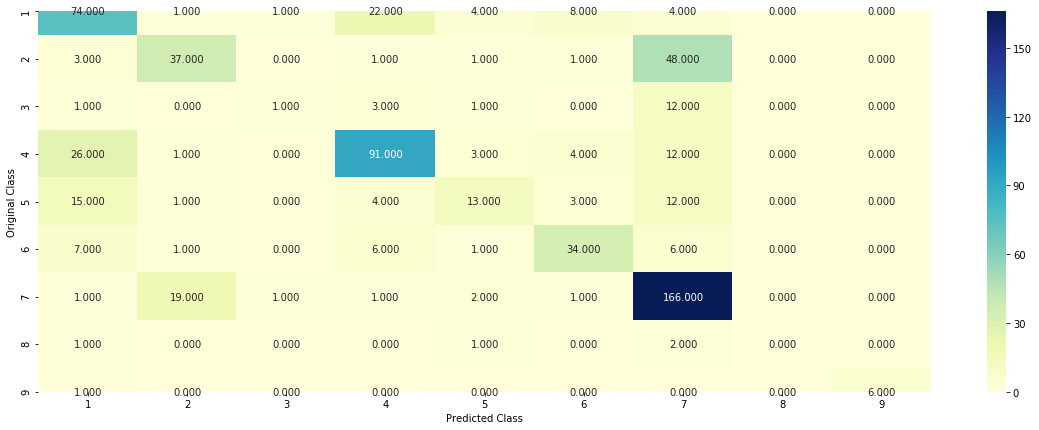

-------------------- Precision matrix (Columm Sum=1) --------------------


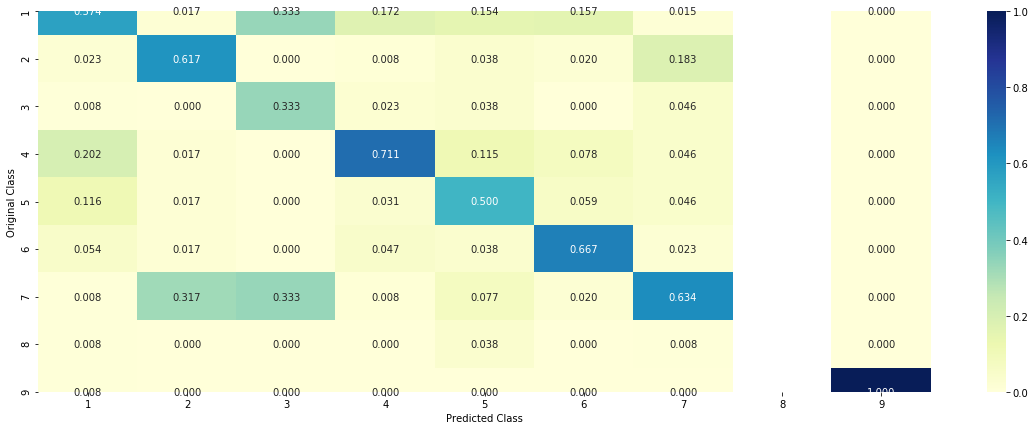

-------------------- Recall matrix (Row sum=1) --------------------


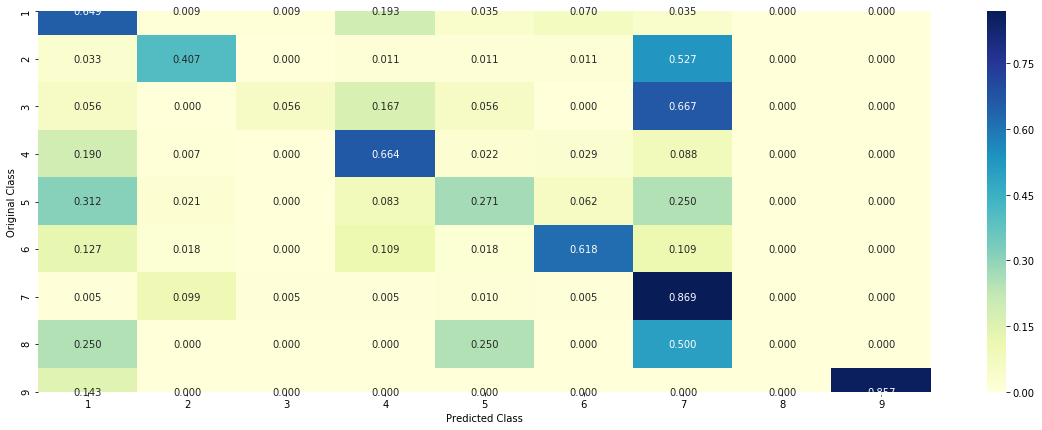

In [78]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

We see here that the loss is higher than that of a LR model. This is happening because we aren't working with a lot of data

The data keeps getting split up between the models while stacking and since we're not using a lot of data here, the model 
doesnt perform as well as expected

# Maximum Voting classifyer

Log loss (train) on the VotingClassifier : 0.9027689796729623
Log loss (CV) on the VotingClassifier : 1.195139950713495
Log loss (test) on the VotingClassifier : 1.2071875287634297
Number of missclassified point : 0.37894736842105264
-------------------- Confusion matrix --------------------


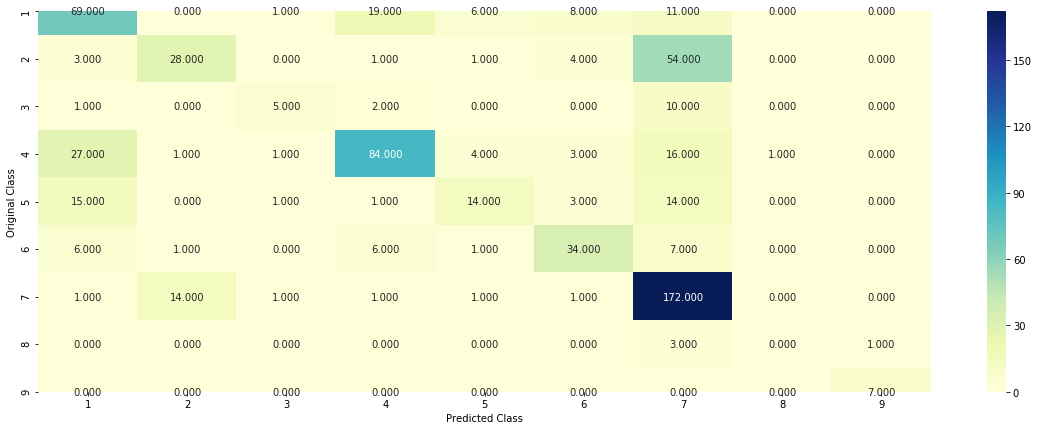

-------------------- Precision matrix (Columm Sum=1) --------------------


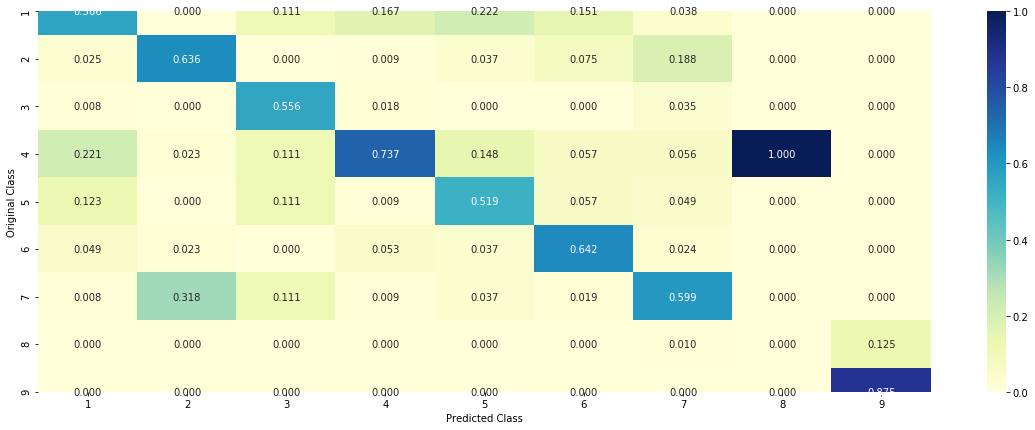

-------------------- Recall matrix (Row sum=1) --------------------


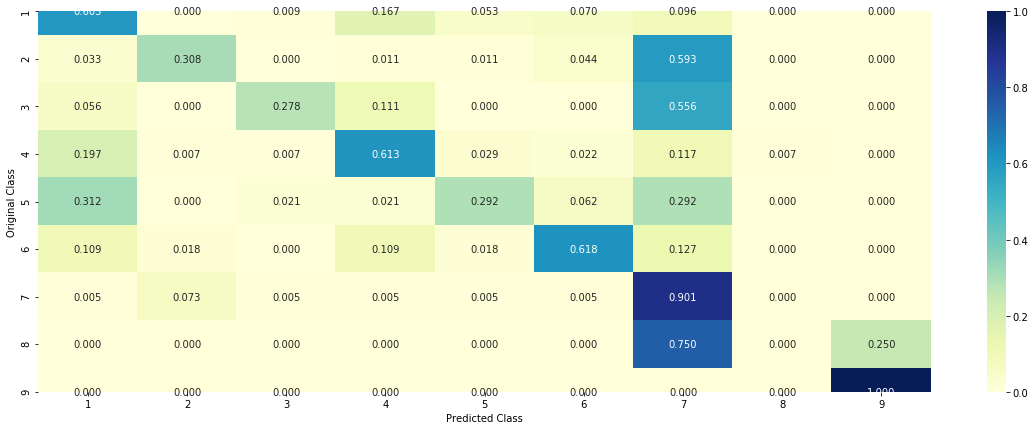

In [79]:
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_onehotCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_onehotCoding))

# Some Conclusions:

1. Featurization is the most important and a lot of time has to be spent so that they work well on the ML models
2. A lot of ML models were tried and tested upon and then later stacked and after using a majority vote, the results were seen and analysed
3. This database did not have to lot of datapoints. The dataset was rather small
4. In the healthcare domain, we look to minimize False negtives as the margin for error can lead to loss of lives
5. Cancer diagnosis isnt an easy problem to solve. Mankind has spent decades trying to solve this. ML can only get closer
   to helping professionals solve this but cannot predict n solve it like black n white 
6. Logistic regression is the best performing model in these given constrains